<a href="https://colab.research.google.com/github/sighfai/DSA4288-Repulsive-Mixtures/blob/main/compare_mixturemodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [28]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, pdist





In [27]:
# Load the air quality dataset
air_quality = pd.read_csv("airquality.csv")

# Drop rows with missing values in 'Ozone' and 'Solar.R'
air_quality_cleaned = air_quality.dropna(subset=['Ozone', 'Solar.R']).copy()

# Get the number of rows after dropping NA
num_rows = air_quality_cleaned.shape[0]
print(f"Number of rows after dropping NA: {num_rows}")

Number of rows after dropping NA: 111


# Gaussian Coulomb prior

In [23]:
# Standardize the selected features
X = air_quality_cleaned[['Ozone', 'Solar.R']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define grid for contour plot
x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
XX = np.array([x.ravel(), y.ravel()]).T

from sklearn.mixture import BayesianGaussianMixture

# Define Dirichlet Process Gaussian Mixture Model with a Poisson-like prior
dp_gmm = BayesianGaussianMixture(
    n_components=20,  # Upper limit to allow for random number of components
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=1.0,  # Higher prior to encourage a random number of components
    covariance_type='full',
    random_state=42
)

# Fit the model to the data
dp_gmm.fit(X_scaled)

# Predict cluster assignments and get means
labels_dp_gmm = dp_gmm.predict(X_scaled)
means_dp_gmm = dp_gmm.means_

# Check how many components were actually used
n_active_components = np.sum(dp_gmm.weights_ > 1e-3)
n_active_components, np.unique(labels_dp_gmm)  # Number of active components and unique labels

# number of components will differ for every run because M is chosen at random


(np.int64(7), array([0, 2, 3]))

<ipython-input-40-56d9e072d210>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


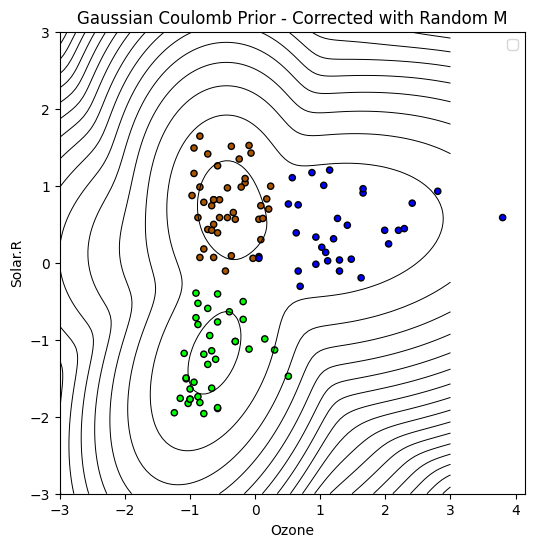

In [40]:
# Generate contour for the Dirichlet Process Gaussian Mixture Model (DPGMM)
Z_dp_gmm = -dp_gmm.score_samples(XX).reshape(x.shape)

# Plot the corrected contour plot with the inferred number of clusters
plt.figure(figsize=(6, 6))

# Generate black-and-white contour
plt.contour(x, y, Z_dp_gmm, levels=20, colors='black', linewidths=0.7)

# Plot all identified clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dp_gmm, cmap='brg', s=20, edgecolors='k')


# Adjust axis labels and title
plt.title("Gaussian Coulomb Prior - Corrected with Random M")
plt.xlabel("Ozone")
plt.ylabel("Solar.R")
plt.legend()
plt.show()



# QQP

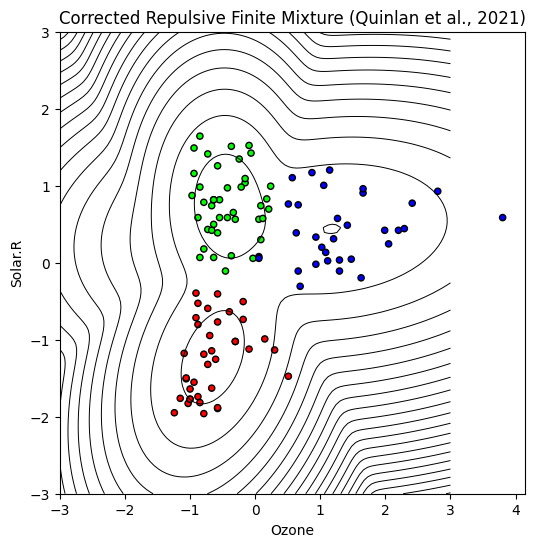

In [39]:
# Repulsion potential based on Quinlan et al. (2021)
def repulsive_potential(distances, c=1.0):
    """Repulsion term based on Gaussian Coulomb-like potential"""
    penalty = np.sum(-np.log(1 - np.exp(-c * distances**2) + 1e-6))  # Add small constant to avoid instability
    return penalty

# Define Repulsive Finite Mixture Model with repulsion potential
class RepulsiveGaussianMixture:
    def __init__(self, n_components=5, zeta=1.0, c=1.0, random_state=42):
        self.n_components = n_components
        self.zeta = zeta
        self.c = c
        self.random_state = random_state
        self.gmm = GaussianMixture(n_components=n_components, random_state=random_state)

    def fit(self, X):
        self.gmm.fit(X)
        # Calculate repulsion penalty based on repulsion potential
        distances = pdist(self.gmm.means_)
        repulsion_penalty = repulsive_potential(distances, c=self.c)
        self.log_likelihood_ = self.gmm.lower_bound_ - self.zeta * repulsion_penalty

    def predict(self, X):
        return self.gmm.predict(X)

    def score_samples(self, X):
        return self.gmm.score_samples(X)

# Fit the Repulsive Gaussian Mixture Model with Coulomb-like repulsion
rfm_gmm = RepulsiveGaussianMixture(n_components=3, zeta=1.0, c=1.0, random_state=42)
rfm_gmm.fit(X_scaled)

# Predict cluster labels and calculate posterior
labels_rfm_gmm = rfm_gmm.predict(X_scaled)

# Calculate contour for RFM model
Z_rfm_gmm = -rfm_gmm.score_samples(XX).reshape(x.shape)

# Plot contour and clusters for Repulsive Finite Mixture
plt.figure(figsize=(6, 6))
plt.contour(x, y, Z_rfm_gmm, levels=20, colors='black', linewidths=0.7)

# Plot cluster points
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_rfm_gmm, cmap='brg', s=20, edgecolors='k')
plt.title("Corrected Repulsive Finite Mixture (Quinlan et al., 2021)")
plt.xlabel("Ozone")
plt.ylabel("Solar.R")
plt.show()



# Non-repulsive prior (AntMAN Equivalent)

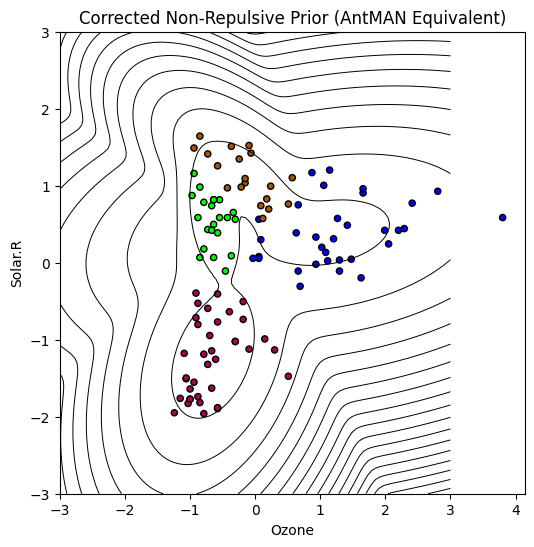

In [38]:
# Corrected Gaussian Mixture Model (GMM) with more components to capture finer clusters
gmm_non_repulsive = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm_non_repulsive.fit(X_scaled)

# Predict cluster labels and calculate posterior
labels_gmm_non_repulsive = gmm_non_repulsive.predict(X_scaled)

# Calculate contour for corrected non-repulsive GMM
Z_gmm_non_repulsive = -gmm_non_repulsive.score_samples(XX).reshape(x.shape)

# --- STEP 4: PLOT NON-REPULSIVE GMM CONTOUR ---
# Plot corrected contour and clusters for Non-Repulsive GMM (AntMAN Equivalent)
plt.figure(figsize=(6, 6))
plt.contour(x, y, Z_gmm_non_repulsive, levels=20, colors='black', linewidths=0.7)

# Plot cluster points with distinct colors
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_gmm_non_repulsive, cmap='brg', s=20, edgecolors='k')
plt.title("Corrected Non-Repulsive Prior (AntMAN Equivalent)")
plt.xlabel("Ozone")
plt.ylabel("Solar.R")
plt.show()

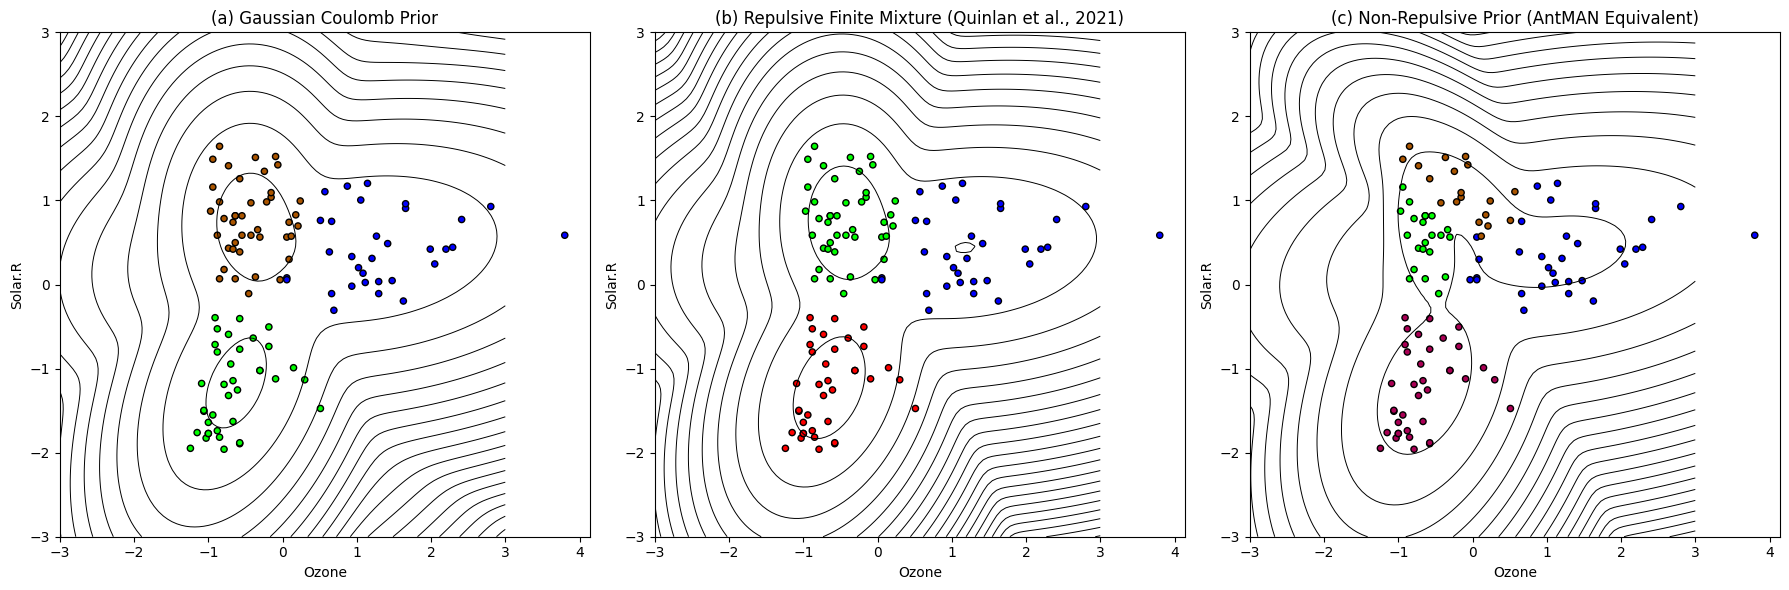

In [36]:
# Plot all three models side-by-side for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- Plot 1: Gaussian Coulomb Prior ---
axes[0].contour(x, y, Z_dp_gmm, levels=20, colors='black', linewidths=0.7)
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dp_gmm, cmap='brg', s=20, edgecolors='k')
axes[0].set_title("(a) Gaussian Coulomb Prior")
axes[0].set_xlabel("Ozone")
axes[0].set_ylabel("Solar.R")

# --- Plot 2: Repulsive Finite Mixture (Quinlan et al., 2021) ---
axes[1].contour(x, y, Z_rfm_gmm, levels=20, colors='black', linewidths=0.7)
axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_rfm_gmm, cmap='brg', s=20, edgecolors='k')
axes[1].set_title("(b) Repulsive Finite Mixture (Quinlan et al., 2021)")
axes[1].set_xlabel("Ozone")
axes[1].set_ylabel("Solar.R")

# --- Plot 3: Non-Repulsive Prior (AntMAN Equivalent) ---
axes[2].contour(x, y, Z_gmm_non_repulsive, levels=20, colors='black', linewidths=0.7)
axes[2].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_gmm_non_repulsive, cmap='brg', s=20, edgecolors='k')
axes[2].set_title("(c) Non-Repulsive Prior (AntMAN Equivalent)")
axes[2].set_xlabel("Ozone")
axes[2].set_ylabel("Solar.R")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()



In the Gaussian Coulomb Prior (GCP) model, the number of components M is drawn from a Poisson prior which introduces randomness into the number of mixture components. This causes the number of clusters to differ across runs.

For the repulsive finite mixture and non-repulsive prior, there is a fixed number of components which leads to consistent clustering across runs. However, the non-repulsive prior lead to more overlapping clusters due to no repulsion and it identies multiple finer clusters.

In conclusion, the repulsive finite mixture (Quinlan et al., 2021) provides the best balance between cluster separation and cluster identification.